In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import StandardScaler

import scipy
import scipy.cluster.hierarchy as sch
import collections

sns.set_style('whitegrid')

# Problem definition

Cluster movies according to vote_count, popularity, revenue, budget, genre, decade etc.

# Load the data

In [2]:
df = pd.read_csv('df_movie_fixed.csv')
print(df.columns)


Index(['budget', 'genres', 'movieId', 'original_language', 'original_title',
       'popularity', 'production_companies', 'production_countries',
       'release_date', 'revenue', 'runtime', 'title', 'vote_average',
       'vote_count', 'keywords'],
      dtype='object')


In [3]:
df.head()

,budget,genres,movieId,original_language,original_title,popularity,production_companies,production_countries,release_date,revenue,runtime,title,vote_average,vote_count,keywords
0,30000000.0,"['Animation', 'Comedy', 'Family']",862,en,Toy Story,21.946943,['Pixar Animation Studios'],['United States of America'],1995-10-30,373554033.0,81.0,Toy Story,7.7,5415.0,"['jealousy', 'toy', 'boy', 'friendship', 'frie..."
1,65000000.0,"['Adventure', 'Fantasy', 'Family']",8844,en,Jumanji,17.015539,"['TriStar Pictures', 'Teitler Film', 'Intersco...",['United States of America'],1995-12-15,262797249.0,104.0,Jumanji,6.9,2413.0,"['board game', 'disappearance', ""based on chil..."
2,16000000.0,"['Comedy', 'Drama', 'Romance']",31357,en,Waiting to Exhale,3.859495,['Twentieth Century Fox Film Corporation'],['United States of America'],1995-12-22,81452156.0,127.0,Waiting to Exhale,6.1,34.0,"['based on novel', 'interracial relationship',..."
3,60000000.0,"['Action', 'Crime', 'Drama', 'Thriller']",949,en,Heat,17.924927,"['Regency Enterprises', 'Forward Pass', 'Warne...",['United States of America'],1995-12-15,187436818.0,170.0,Heat,7.7,1886.0,"['robbery', 'detective', 'bank', 'obsession', ..."
4,35000000.0,"['Action', 'Adventure', 'Thriller']",9091,en,Sudden Death,5.231580,"['Universal Pictures', 'Imperial Entertainment...",['United States of America'],1995-12-22,64350171.0,106.0,Sudden Death,5.5,174.0,"['terrorist', 'hostage', 'explosive', 'vice pr..."


In [4]:
#Just like to have the title column as the first column
cols = [df.columns[-4]] + [col for col in df if col != df.columns[-4]]
df = df[cols]

In [5]:
df.columns

Index(['title', 'budget', 'genres', 'movieId', 'original_language',
       'original_title', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'vote_average', 'vote_count', 'keywords'],
      dtype='object')

Converting release date to panda's datetime and then dividing them into decades to Facilitate Analysis and reduce the number of columns on the model.

In [6]:
df['release_date'] = pd.to_datetime(df['release_date'])

In [7]:
df['year']=(df['release_date'].dt.year)

In [8]:
print(df['year'].max())
print(df['year'].min())

2017
1915


In [9]:
#Define bins
bins=(1910,1920,1930,1940,1950,1960,1970,1980,1990,2000,2010,2020)

In [10]:
group_names=['1910','1920','1930','1940','1950','1960','1970','1980','1990','2000','2010']

In [11]:
df['decade']=pd.cut(df['year'],bins,labels=group_names)

In [12]:
df.tail()

,title,budget,genres,movieId,original_language,original_title,popularity,production_companies,production_countries,release_date,revenue,runtime,vote_average,vote_count,keywords,year,decade
5215,The Emoji Movie,50000000.0,"['Comedy', 'Family', 'Animation']",378236,en,The Emoji Movie,33.694599,"['Columbia Pictures', 'Sony Pictures Animation']",['United States of America'],2017-07-28,66913939.0,86.0,5.8,327.0,"['app', 'emoji', 'smartphone']",2017,2010
5216,Wind River,11000000.0,"['Action', 'Crime', 'Mystery', 'Thriller']",395834,en,Wind River,40.796775,"['Thunder Road Pictures', 'Star Thrower Entert...","['United Kingdom', 'United States of America',...",2017-08-03,184770205.0,111.0,7.4,181.0,"['rape', 'mountain', 'gun', 'investigation', '...",2017,2010
5217,Savages,800000.0,"['Comedy', 'Drama']",62757,en,Dikari,0.903061,[],[],2006-11-23,1328612.0,100.0,5.8,6.0,[],2006,2000
5218,Pro Lyuboff,2000000.0,"['Romance', 'Drama']",63281,en,Про любоff,0.121844,['Profit'],['Russia'],2010-09-30,1268793.0,107.0,4.0,3.0,[],2010,2000
5219,Antidur,5000000.0,"['Action', 'Comedy', 'Crime', 'Foreign']",63898,ru,Антидурь,0.039793,[],['Russia'],2007-09-06,1413000.0,91.0,1.0,1.0,[],2007,2000


# Feature Engineering 

Normalizing Revenue and Budget

In [13]:
df["revenue_log"]=df['revenue'].apply(np.log)
df["budget_log"]=df['budget'].apply(np.log)

In [14]:
# dummies for genres needs some formatting before dummy creation.
dummies = {}
for mixcol in ['genres']:
    df[str(mixcol)] = df[str(mixcol)].apply(lambda x: x.strip("[]"))


In [15]:
df.columns

Index(['title', 'budget', 'genres', 'movieId', 'original_language',
       'original_title', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'vote_average', 'vote_count', 'keywords', 'year', 'decade',
       'revenue_log', 'budget_log'],
      dtype='object')

In [16]:
df_genres=df["genres"].str.get_dummies(sep=', ')

In [17]:
df_genres.head()

,'Action','Adventure','Animation','Comedy','Crime','Documentary','Drama','Family','Fantasy','Foreign','History','Horror','Music','Mystery','Romance','Science Fiction','TV Movie','Thriller','War','Western'
0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
3,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
4,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [18]:
#Decade dummy dataframe
df_decade=df["decade"].str.get_dummies(sep=', ')

In [19]:
#Dropping unnecessary columns
df=df.drop(['movieId','budget','revenue','original_language','original_title', 'genres','production_companies','production_countries', 'keywords','release_date','year'], axis=1)

In [20]:
#concatinating Dataframes
df=pd.concat([df,df_genres,df_decade],axis=1)

In [21]:
df.head()

,title,popularity,runtime,vote_average,vote_count,decade,revenue_log,budget_log,'Action','Adventure',...,1920,1930,1940,1950,1960,1970,1980,1990,2000,2010
0,Toy Story,21.946943,81.0,7.7,5415.0,1990,19.738573,17.216708,0,0,...,0,0,0,0,0,0,0,1,0,0
1,Jumanji,17.015539,104.0,6.9,2413.0,1990,19.386893,17.989898,0,1,...,0,0,0,0,0,0,0,1,0,0
2,Waiting to Exhale,3.859495,127.0,6.1,34.0,1990,18.215526,16.588099,0,0,...,0,0,0,0,0,0,0,1,0,0
3,Heat,17.924927,170.0,7.7,1886.0,1990,19.048952,17.909855,1,0,...,0,0,0,0,0,0,0,1,0,0
4,Sudden Death,5.231580,106.0,5.5,174.0,1990,17.979850,17.370859,1,1,...,0,0,0,0,0,0,0,1,0,0


In [22]:
df.columns


Index(['title', 'popularity', 'runtime', 'vote_average', 'vote_count',
       'decade', 'revenue_log', 'budget_log', ''Action'', ''Adventure'',
       ''Animation'', ''Comedy'', ''Crime'', ''Documentary'', ''Drama'',
       ''Family'', ''Fantasy'', ''Foreign'', ''History'', ''Horror'',
       ''Music'', ''Mystery'', ''Romance'', ''Science Fiction'', ''TV Movie'',
       ''Thriller'', ''War'', ''Western'', '1910', '1920', '1930', '1940',
       '1950', '1960', '1970', '1980', '1990', '2000', '2010'],
      dtype='object')

In [23]:
df.shape

(5220, 39)

In [24]:
# select the columns
X_columns = ['vote_count','runtime','revenue_log','budget_log','popularity','vote_average']+ list(df_genres.columns)+ list(df_decade.columns)


In [25]:
# normalize the data
for col in ['vote_count','runtime','popularity','vote_average']:
    df[col] = StandardScaler().fit_transform(df[col].values.reshape(-1, 1))

# Model Training

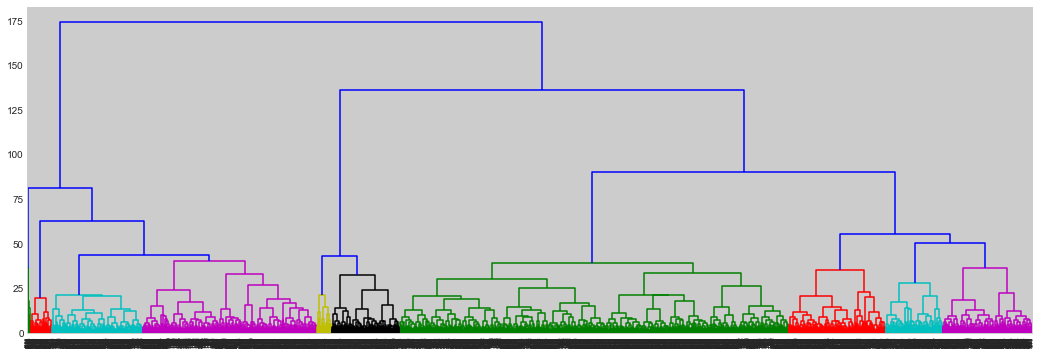

{1, 2, 3, 4, 5, 6, 7, 8}
Counter({5: 2025, 3: 1377, 6: 504, 8: 463, 4: 425, 7: 297, 2: 112, 1: 17})


In [42]:
plt.figure(figsize=(18,6))
k = 8
color_threshold = 43
d = sch.distance.pdist(df[X_columns])
Z= sch.linkage(d, method = 'ward') # minimize within cluster variation
T = sch.fcluster(Z, k, 'maxclust')
P = sch.dendrogram(Z, color_threshold=color_threshold)
plt.show()

print(set(T))
print(collections.Counter(T))

df_results = df.copy()
df_results['cluster'] = T
df['cluster'] = T

In [27]:
# Analyze the results
for cluster in set(T):
    print((cluster), (len(df_results[df_results['cluster']==cluster]['title'])))
    print(sorted(list(df_results[df_results['cluster']==cluster]['title'])))

1 17
['Avatar', 'Baby Driver', 'Beauty and the Beast', 'Big Hero 6', 'Captain America: Civil War', 'Deadpool', 'Gone Girl', 'Guardians of the Galaxy Vol. 2', 'John Wick', 'Minions', 'Pirates of the Caribbean: Dead Men Tell No Tales', 'Pulp Fiction', 'The Avengers', 'The Dark Knight', 'The Hunger Games: Mockingjay - Part 1', 'War for the Planet of the Apes', 'Wonder Woman']
2 112
['2012', '300', 'Ant-Man', 'Armageddon', 'Arrival', 'Avengers: Age of Ultron', 'Batman Begins', 'Batman v Superman: Dawn of Justice', 'Captain America: The First Avenger', 'Captain America: The Winter Soldier', 'Casino Royale', 'Cast Away', 'Dawn of the Planet of the Apes', 'Divergent', 'Django Unchained', 'Doctor Strange', 'Edge of Tomorrow', 'Fantastic Beasts and Where to Find Them', 'Fast & Furious 6', 'Fast Five', 'Fight Club', 'Forrest Gump', 'Furious 7', 'Gladiator', 'Gravity', 'Guardians of the Galaxy', 'Harry Potter and the Chamber of Secrets', 'Harry Potter and the Deathly Hallows: Part 1', 'Harry Pott

In [28]:
# Analyze the centroids
df_results.groupby('cluster').mean().round(2).T

cluster,1,2,3,4,5,6,7,8
popularity,13.58,1.10,0.21,-0.39,-0.09,-0.25,-0.27,-0.18
runtime,0.96,1.28,0.14,-0.54,-0.18,-0.34,1.93,-0.33
vote_average,1.09,0.93,0.17,-0.41,-0.19,-0.61,0.64,0.70
vote_count,4.71,4.12,0.56,-0.53,-0.28,-0.46,-0.44,-0.33
revenue_log,20.31,20.24,18.85,12.09,17.22,15.07,16.36,15.95
budget_log,18.43,18.70,17.73,14.26,16.71,15.84,15.43,14.22
'Action',0.65,0.75,0.34,0.11,0.24,0.23,0.26,0.15
'Adventure',0.59,0.75,0.32,0.05,0.12,0.11,0.12,0.11
'Animation',0.12,0.01,0.16,0.01,0.02,0.02,0.00,0.03
'Comedy',0.29,0.04,0.38,0.36,0.40,0.22,0.18,0.29


# Cluster Descriptions

Cluster 1:
    Cluster 1 has the movies with the largest revenues and one of the largest budgets. Action, Fantasy and Adventure are the main Genres. Which we can see makes sense with movies like 'Avatar', 'Minions' and 'The Avengers'. These movies are mostly from the last decade ('2010' decade). They also have the highest popuarity score, and the most number of TMDB voters.
    
Cluster 2:
    Cluster 2 is still on the high revenue side, but a little lower than cluster 1. It is, however, also higher on the budget scale. Action, Adventure, Thriller are Drama are reocuuring Genres. It is significantly lower on the popularity scale but has a comparable vote count to those in Cluster 1 (little lower). These movies also have a sort of split in that they were released in the last two decades (the 2000s, and 2010s). Here you see many movies like 'Spider men',' X-men','Transformers','Lord of the Rings', etc. 

Cluster 3:
    Cluster 3 is now lower on both the budget and revenue scale from cluster 1 - yet still on the high side compared to the other clusters below. Comedy, Drama and Thriller are the prominent themes. We also have movies in this cluster that were released as far back as the 70s. They are less popular from the previous two clusters, and have a significant drop in vote counts. This one has movies like 'The Flinstones' and 'Pinocchio'.
 
Cluster 4: 
    Cluster 4 has the lowest revenue and budgets. There is a significant drop in popularity and vote counts. The Genres is more spread out, but Drama, Romance, Comedy and Thriller hold a prominence. This cluster contains releases that data as far back as the 20s decade.     
    
Cluster 5:
    Cluster 5 climbs up from cluster 4 in regards to popularity, vote count, revenue and budget. However, on the grand scale, it is still significantly lower than the first 3 clusters. The popular Genre's are comparable to cluster 4 as the popular themes are Drama, Comedy, Romance and Thriller. Cluster 5 has one of the highest numbers of Romance films. The movies in this cluster are released as far back as the 70s and many are from the 2000 decade.
    
Cluster 6:
    Cluster 6 sees a drop in budget and revenue from cluster 5. It has the lowest vote count and one of the lowest popularity ratings. Drama is the most significant Genre. It also has the most number of horror films compared to any other cluster. The movies in this cluster are realeased as far back as the 60s, but many from the last decade are there as well. It has the most number of films from the 80s compared to any other cluster. It also has movies with the lowest runtime.
    
Cluster 7:
    Cluster 7 is lowest on the TMDB popularity scale. It has the highest runtime, and a higher vote average than the previous cluster. The revenue also climbs up from the previous cluster. All though the Genres in this cluster are more spread out, Drama and Romance are the highest in this cluster compared to the others. The release dates are also more spread out, and go as far back as the 20s decade; there is a more even spread in the last three decades compared to any of the other clusters. I suspect many Hindi movies will be in this cluster because of the runtime...and yes, here we find many Hindi movies such as :'Dear Zindagi', 'Dhoom 2', 'Dhoom 3', 'Dil Chahta Hai', 'Dil Dhadakne Do', 'Dil Se..', 'Dil To Pagal Hai', 'Dilwale', 'Dilwale','Dostana'. It would make sense that the foreign films have a low popularity weight in the TMDB database, as it is a more US based collection of movies.
    
    
Cluster 8:
    Cluster 8 is lowest on the budget scale and one of the lowest on the revenue scale. It is also low on the popularity, runtime and vote count scale. The Genres are much more spread out, but Drama, Thriller and Comedy holds a significant weight in this cluster. It also has the highest number of Crime films compared to the other clusters. This cluster has a significant spread in terms of release dates. but the majority of the files are from the 70s - it has the most number of films released in that decade compared to any other cluster. 
    
    
    
    

vote_count


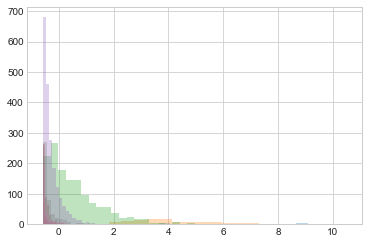

runtime


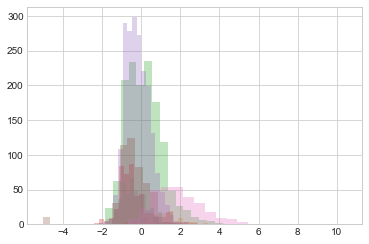

revenue_log


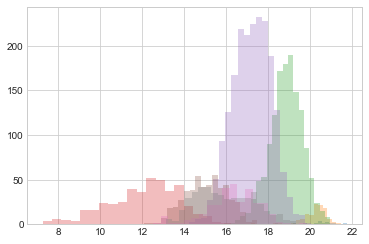

budget_log


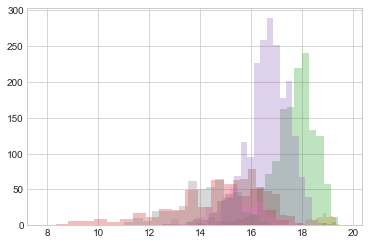

popularity


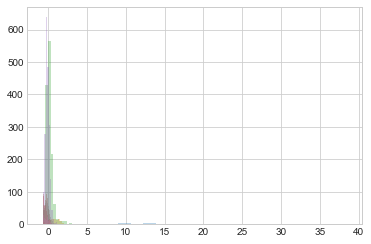

vote_average


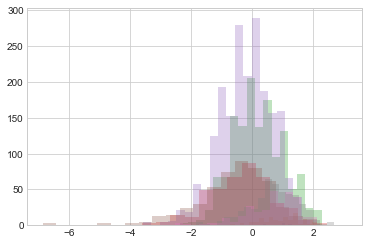

'Action'


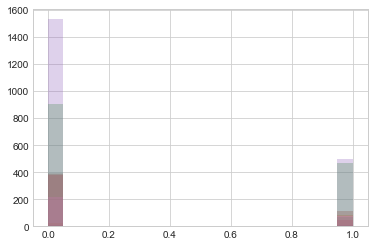

'Adventure'


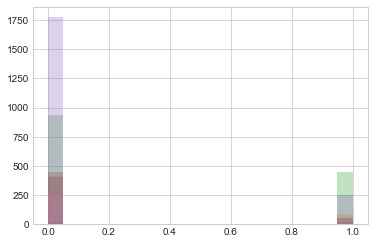

'Animation'


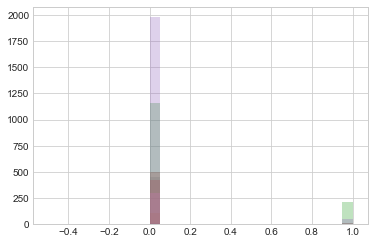

'Comedy'


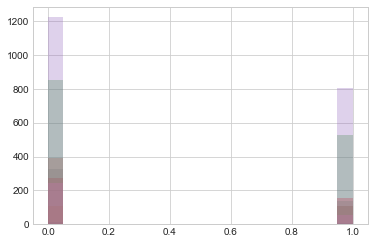

'Crime'


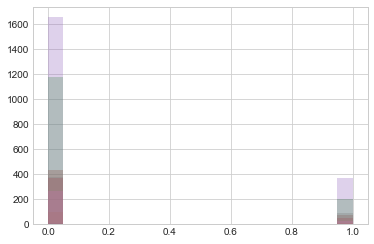

'Documentary'


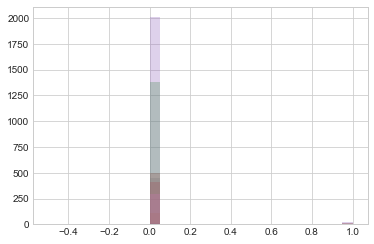

'Drama'


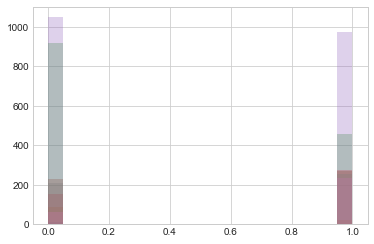

'Family'


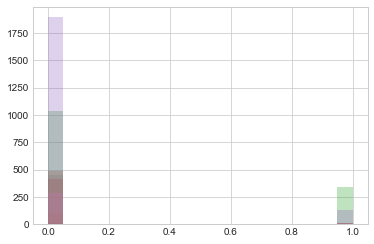

'Fantasy'


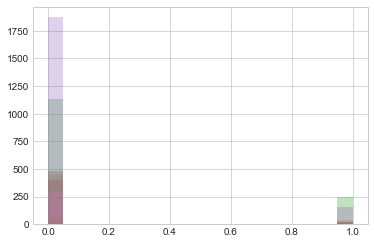

'Foreign'


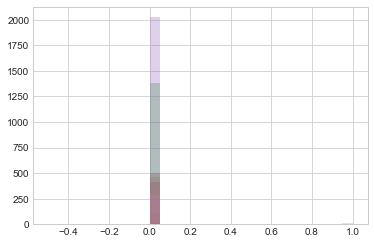

'History'


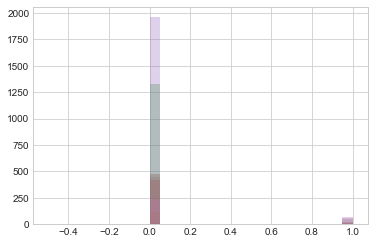

'Horror'


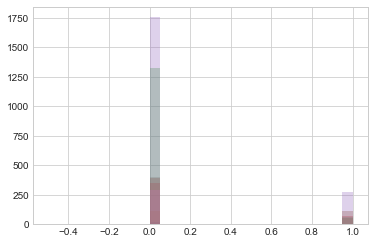

'Music'


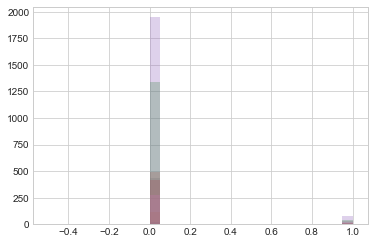

'Mystery'


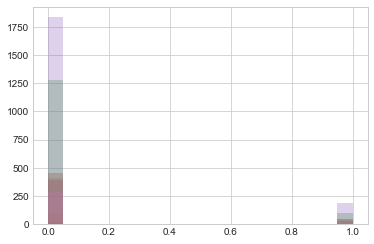

'Romance'


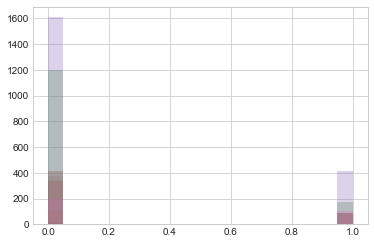

'Science Fiction'


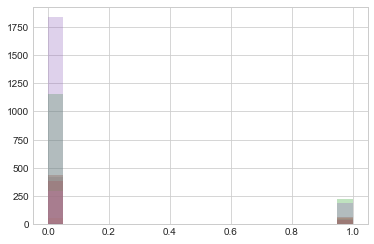

'TV Movie'


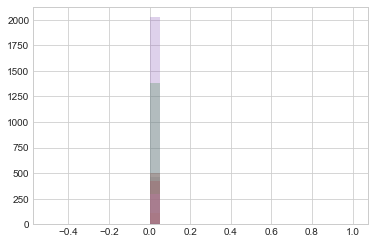

'Thriller'


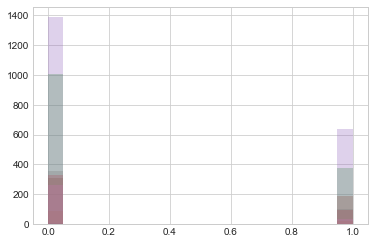

'War'


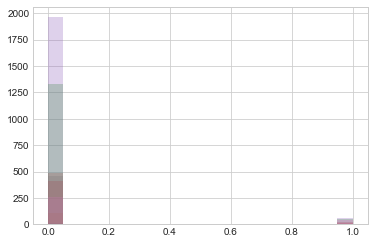

'Western'


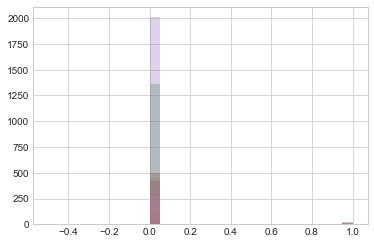

1910


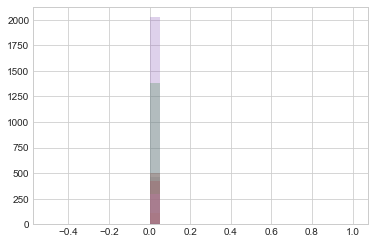

1920


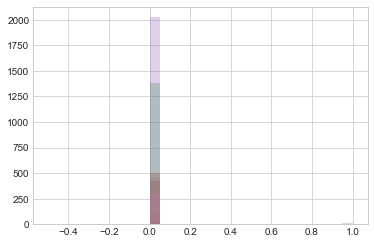

1930


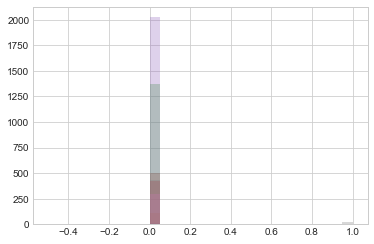

1940


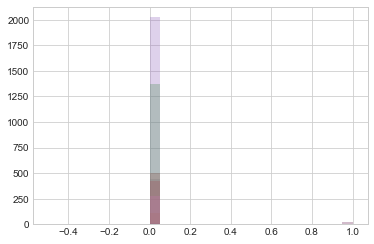

1950


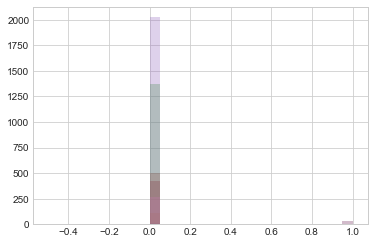

1960


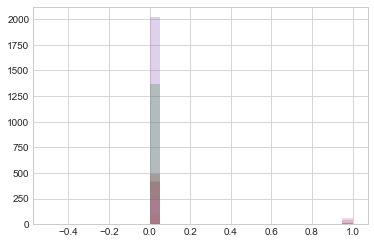

1970


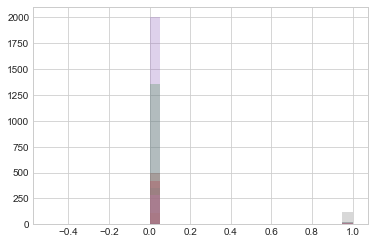

1980


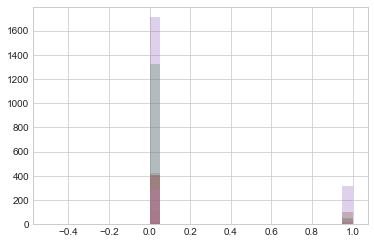

1990


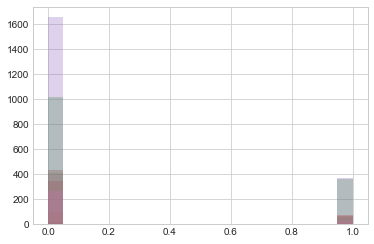

2000


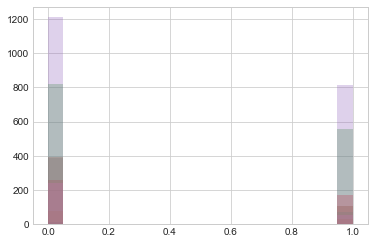

2010


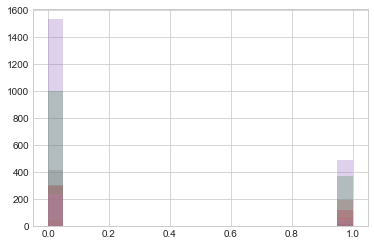

In [29]:
# Analyze the results
for col in X_columns:
    print(col)
    for cluster in set(T):
        plt.hist(df_results[df_results['cluster']==cluster][col], label=str(cluster), alpha=0.3, bins=20)
    #plt.legend()
    plt.show()

8
vote_count


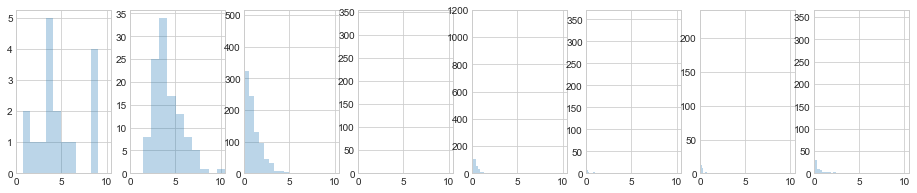

runtime


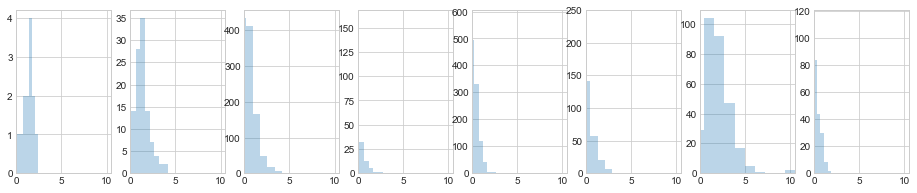

revenue_log


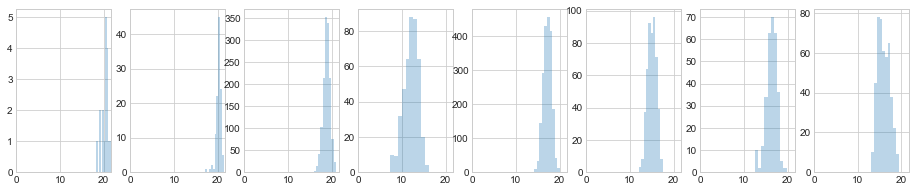

budget_log


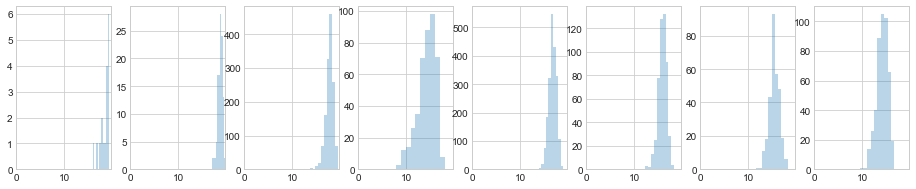

popularity


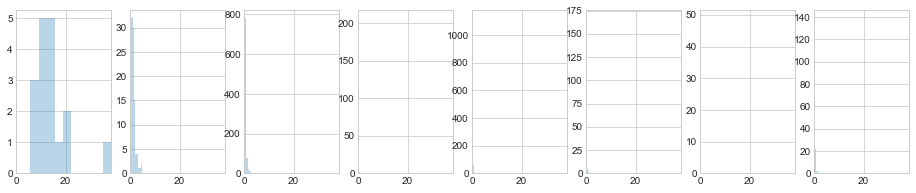

vote_average


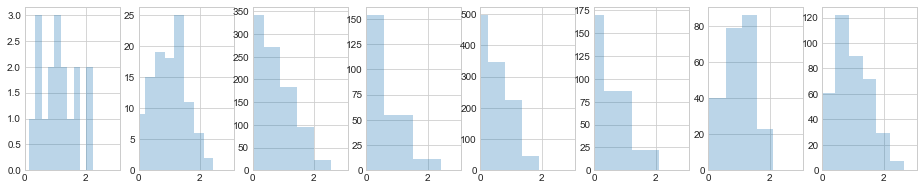

'Action'


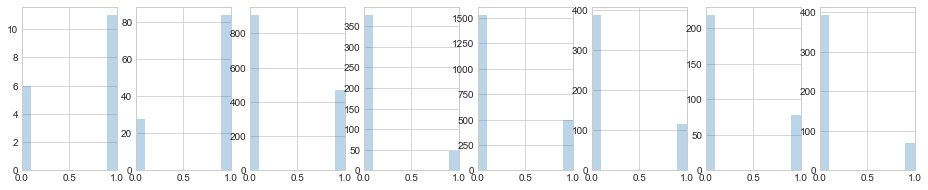

'Adventure'


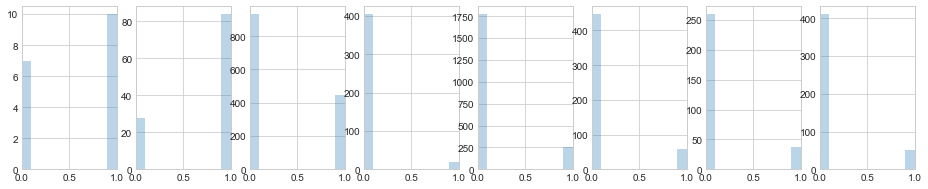

'Animation'


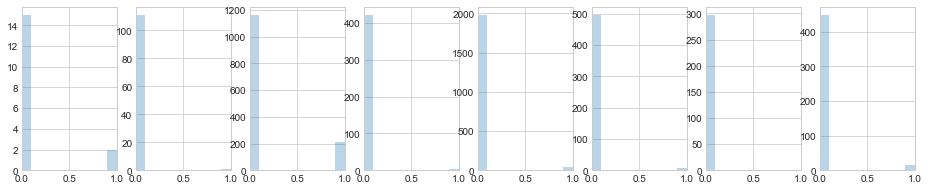

'Comedy'


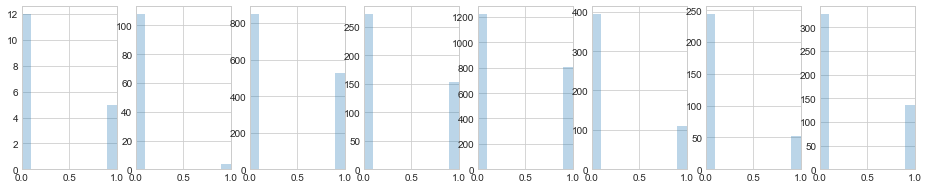

'Crime'


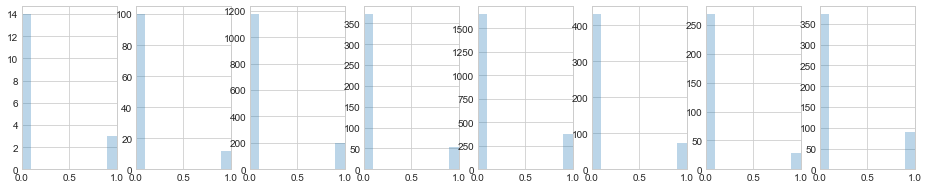

'Documentary'


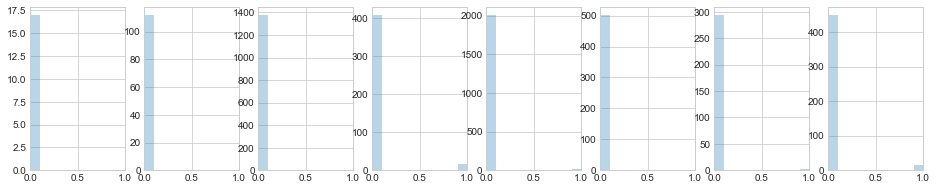

'Drama'


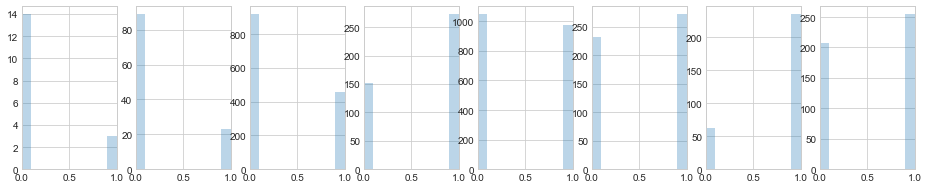

'Family'


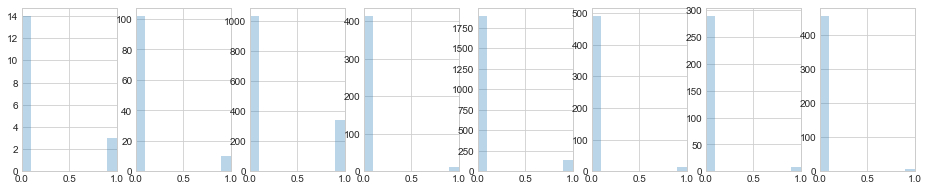

'Fantasy'


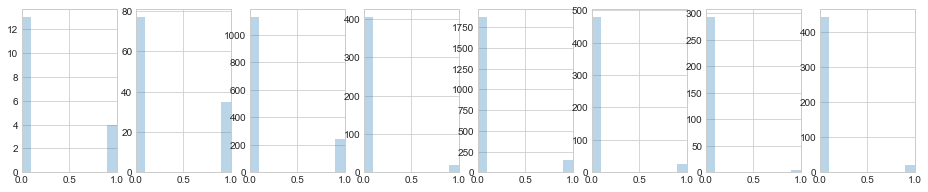

'Foreign'


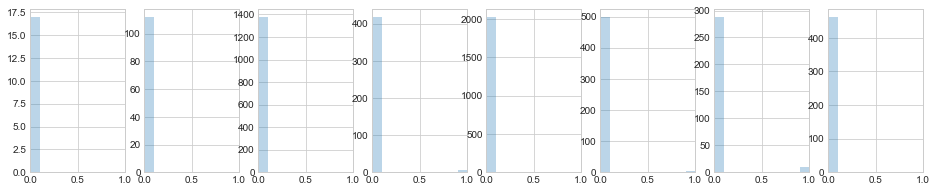

'History'


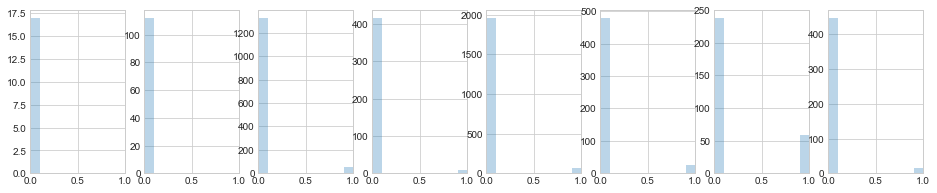

'Horror'


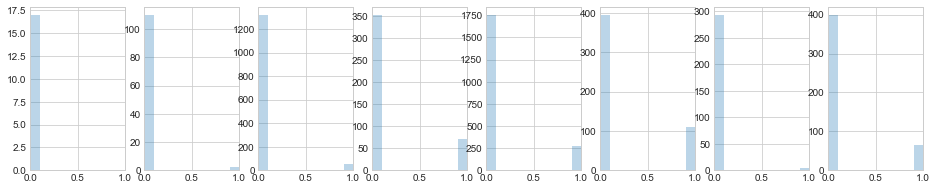

'Music'


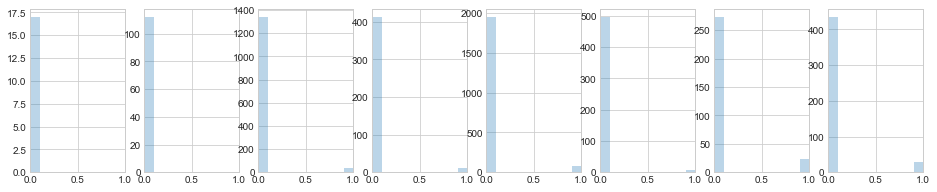

'Mystery'


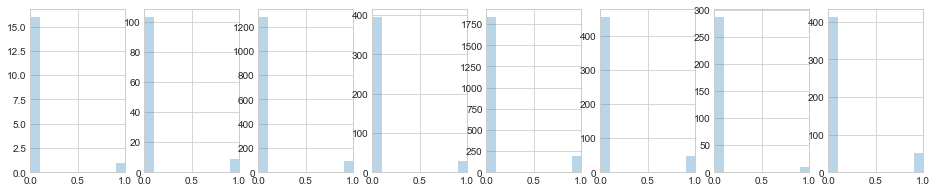

'Romance'


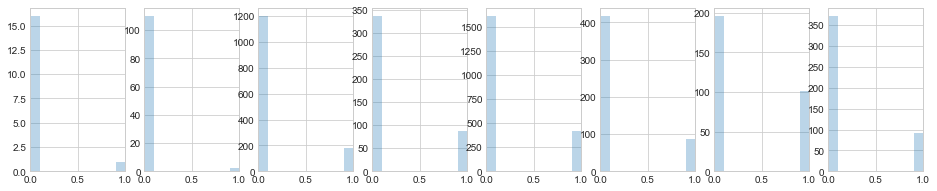

'Science Fiction'


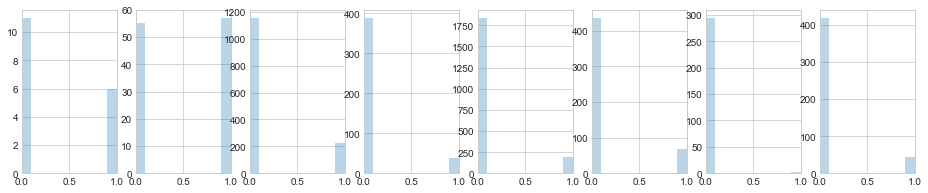

'TV Movie'


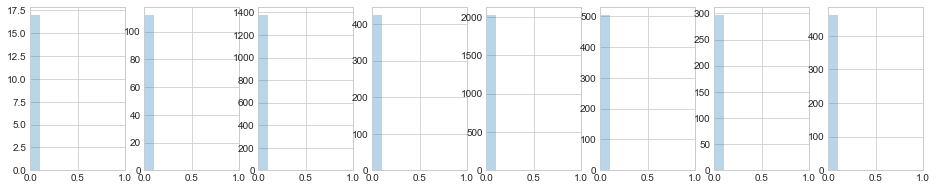

'Thriller'


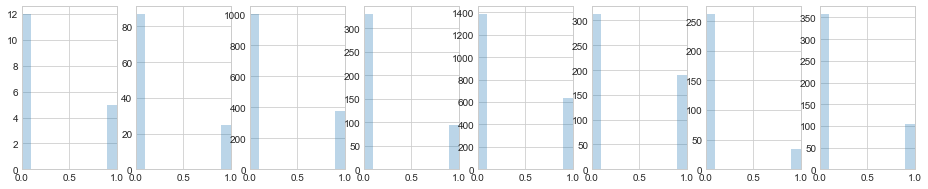

'War'


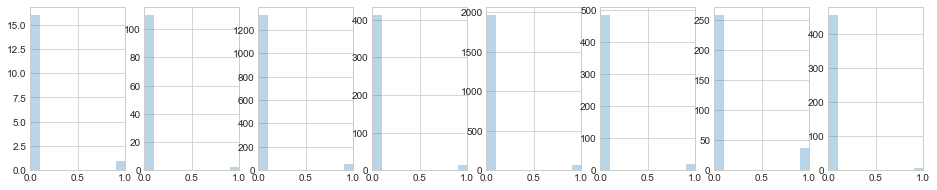

'Western'


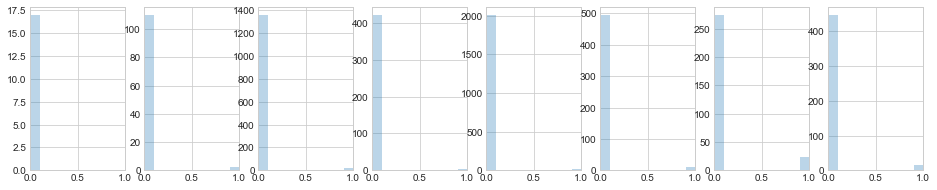

1910


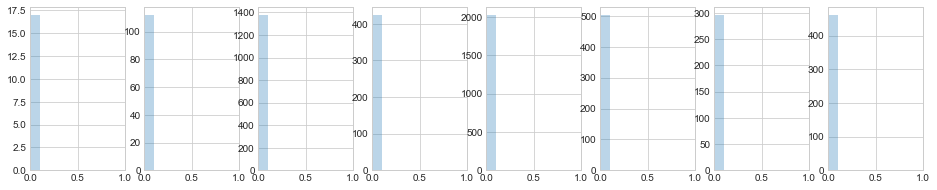

1920


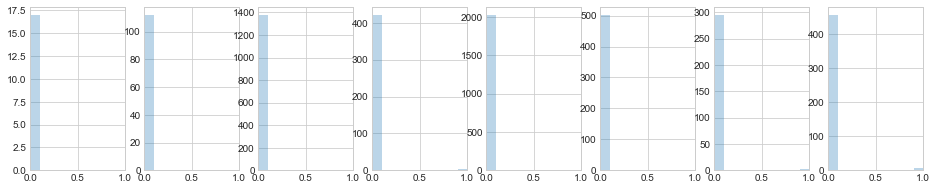

1930


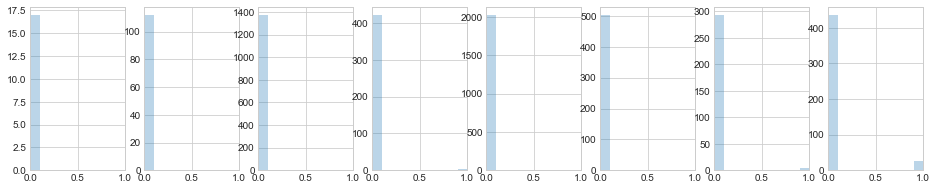

1940


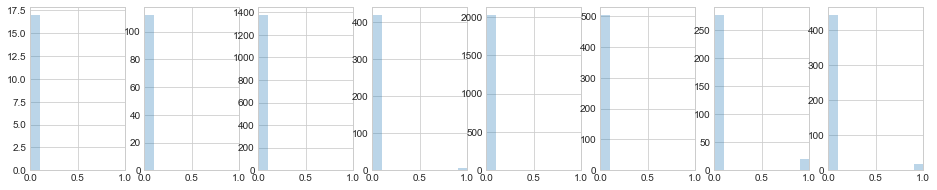

1950


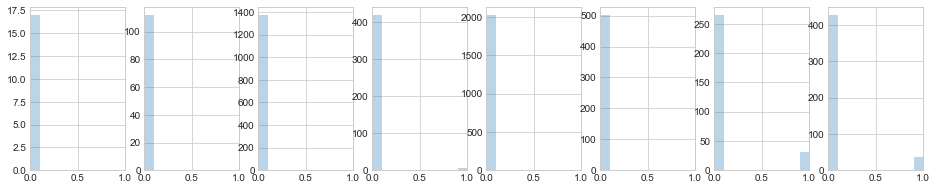

1960


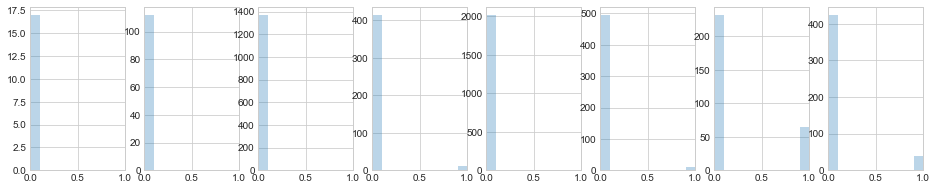

1970


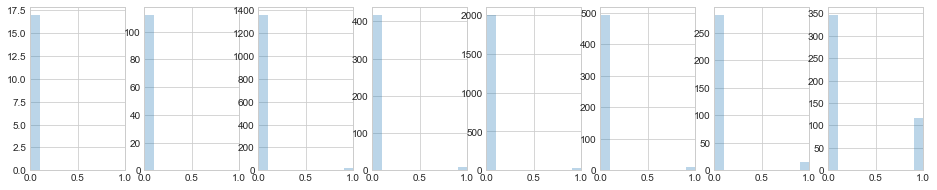

1980


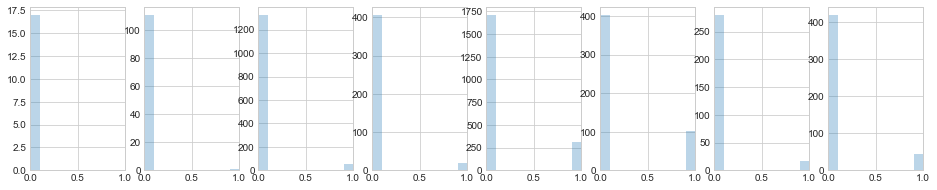

1990


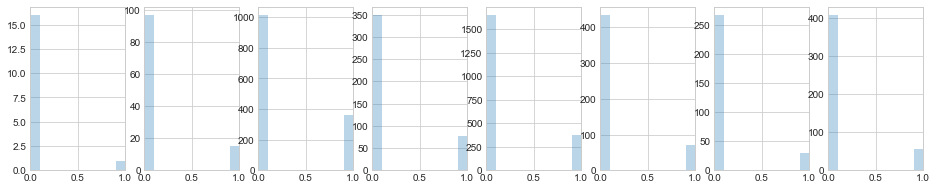

2000


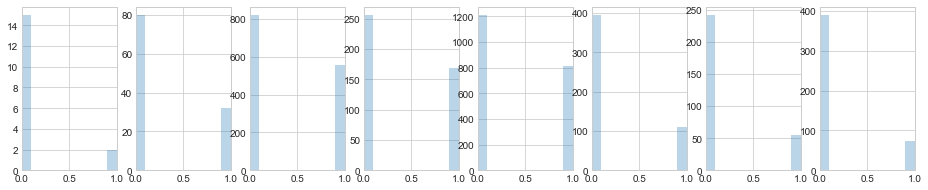

2010


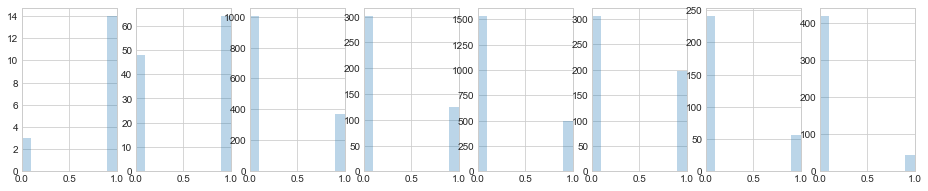

In [30]:
# Analyze the results
n_clusters = len(set(T))
print(n_clusters)
for col in X_columns:
    print(col)
    i = 1
    plt.figure(figsize=(16,3))
    for cluster in sorted(set(T)):
        plt.subplot(1, n_clusters, i)
        plt.xlim([0,df_results[col].max()])
        plt.hist(df_results[df_results['cluster']==cluster][col], label=str(cluster), alpha=0.3, bins=10)
        i += 1
    plt.show()

revenue_log


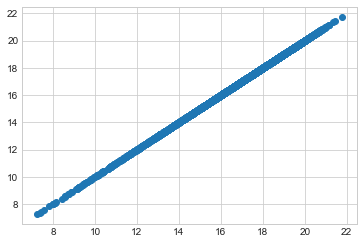

budget_log


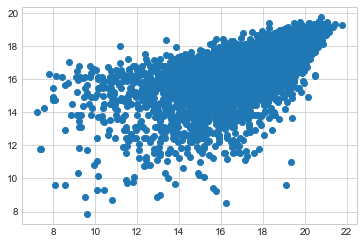

popularity


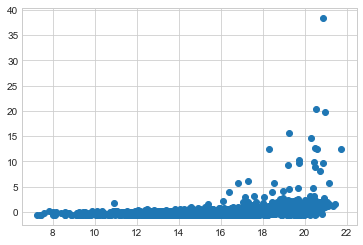

vote_average


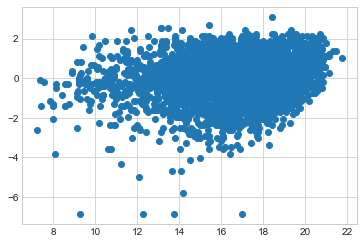

vote_count


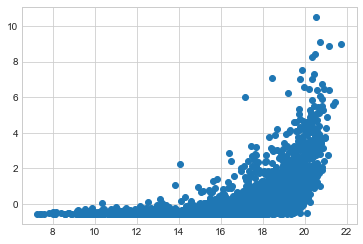

runtime


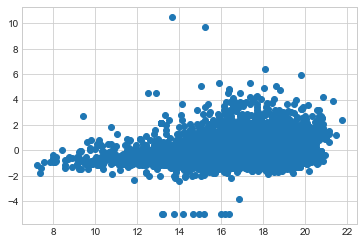

In [31]:
# Analyze the correlation with revenue
for c in ['revenue_log', 'budget_log', 'popularity', 'vote_average', 'vote_count', 'runtime']:
    print(c)
    plt.plot(df_results['revenue_log'], df_results[c], 'o')
    plt.show()

# Model Evaluation

In [32]:
# Inter-Cluster
centroids = []
for cluster in sorted(set(T)):
    centroids.append(df[df['cluster']==cluster][X_columns].mean().values)
distances = []
for c1 in centroids:
    for c2 in centroids:
        distances.append(euclidean_distances(c1.reshape(-1, 1), c2.reshape(-1, 1))[0][0])
print('Inter Cluster distance', np.mean(distances))

# Intra-Cluster
distances = []
for cluster in sorted(set(T)):
    df_filter = df[df['cluster']==cluster]
    centroid = df_filter[X_columns].mean().values
    for k, v in df_filter[X_columns].iterrows():
        distances.append(euclidean_distances(centroid.reshape(-1, 1), v.values.reshape(-1, 1))[0][0])
print('Intra Cluster distance', np.mean(distances))

# Inertia
distances = []
for cluster in sorted(set(T)):
    df_filter = df[df['cluster']==cluster]
    centroid = df_filter[X_columns].mean().values
    for k, v in df_filter[X_columns].iterrows():
        distances.append(euclidean_distances(centroid.reshape(1, -1), v.values.reshape(1, -1), squared=True)[0][0])
print('Inertia', np.sum(distances))

Inter Cluster distance 1.9556851536452065
Intra Cluster distance 0.37317048677189785
Inertia 35847.89903569991


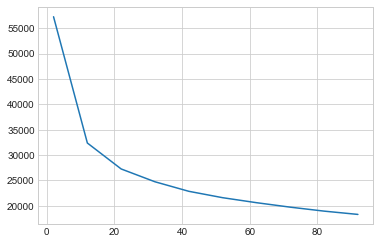

In [33]:
inertia = []
number_k = []
for k in range(2,100,10):
    d = sch.distance.pdist(df[X_columns])
    Z= sch.linkage(d, method = 'ward')
    T = sch.fcluster(Z, k, 'maxclust')
    df['cluster'] = T

    # Inertia
    distances = []
    for cluster in sorted(set(T)):
        df_filter = df[df['cluster']==cluster]
        centroid = df_filter[X_columns].mean().values
        for _, v in df_filter[X_columns].iterrows():
            distances.append(euclidean_distances(centroid.reshape(1, -1), v.values.reshape(1, -1), squared=True)[0][0])
    inertia.append(np.sum(distances))
    number_k.append(k)
plt.plot(number_k, inertia)
plt.show()

A k of 23(ish) would give the best results it seems.
